# Idee
Eine weitere Idee zum bereits erreichten ist, einen Schnitt der Auslastung auf allen Parkhäuser in der Stadt Zürich anzuwenden. Ziel ist es eine Hervorsage der Auslastung auf alle Parkhäuser pro Stunde zu machen.

# Vorgehen
Da das Modell über das ganze Jahr ungleichmässige Daten aufweist, wurden 5 Monate, welche sich einigermassen ähnlich sind ausgewählt und später basierend auf diesen Berechnungen eine Hervorsage getroffen.

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Random Forest wird importiert
from sklearn.ensemble import RandomForestRegressor
import numpy as np

import matplotlib.pyplot as plt
forest = RandomForestRegressor(n_estimators=9)

In [80]:
df = pd.read_pickle("./data.pkl")
mask = (df['date'] > '2020-06-01') & (df['date'] <= '2020-12-31')
df = df.loc[mask]
df = df[df.month != 10]

In [81]:
# mittelwerte pro parkhaus pro zeiteinheit wird errechnet
by_hour = df.groupby([df.parking_id, df.date.dt.date, df.hour]).mean()
# über ganz Zürich gesamt freie Parkplätze pro Stunde
test = by_hour[['free_parking_0']].reset_index()
result = test.groupby([test.date, test.hour]).sum()[['free_parking_0']]
result = result.reset_index()
# normiert
result.free_parking_0 = result.free_parking_0 / result.free_parking_0.max()
df = result
df

,date,hour,free_parking_0
0,2020-07-18,0,0.815932
1,2020-07-18,1,0.830450
2,2020-07-18,2,0.838063
3,2020-07-18,3,0.840675
4,2020-07-18,4,0.837059
...,...,...,...
3235,2020-12-30,19,0.845550
3236,2020-12-30,20,0.867257
3237,2020-12-30,21,0.873866
3238,2020-12-30,22,0.901136


In [82]:
# Funktion um alle Datensaätze der Nacht herauszufiltern.
def daypart(hour):
    if hour in [23,0,1,2,3,4,5]:
        return "0"
    else: return "1"
    
# methode auf daten anwenden
df['daypart'] = df['hour'].apply(daypart)
df

,date,hour,free_parking_0,daypart
0,2020-07-18,0,0.815932,0
1,2020-07-18,1,0.830450,0
2,2020-07-18,2,0.838063,0
3,2020-07-18,3,0.840675,0
4,2020-07-18,4,0.837059,0
...,...,...,...,...
3235,2020-12-30,19,0.845550,1
3236,2020-12-30,20,0.867257,1
3237,2020-12-30,21,0.873866,1
3238,2020-12-30,22,0.901136,1


In [83]:
# Nur Datensätze wenn es Tag ist
df = df[df.daypart == "1"]

,date,hour,free_parking_0,daypart
6,2020-07-18,6,0.961163,1
7,2020-07-18,7,0.968141,1
8,2020-07-18,8,0.946708,1
9,2020-07-18,9,0.890646,1
10,2020-07-18,10,0.820173,1
...,...,...,...,...
3234,2020-12-30,18,0.778089,1
3235,2020-12-30,19,0.845550,1
3236,2020-12-30,20,0.867257,1
3237,2020-12-30,21,0.873866,1


In [84]:
from sklearn.model_selection import GroupKFold

def data_kfold_train(df, parkingid, n_splits = 10):
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df['month'] = df['date'].dt.month
    df['day_of_month'] = df['date'].dt.day
    df['dayname_of_week'] = df['date'].dt.day_name()
    df["day_of_week"] = df["dayname_of_week"].astype('category')
    df["day_of_week"] = df["day_of_week"].cat.codes
    df['is_weekend'] = df['dayname_of_week'].apply(lambda x : 1 if x in ['Saturday','Sunday'] else 0)
    print(df)
    group_kfold = GroupKFold(n_splits=n_splits)
    X = df[['hour', 'is_weekend', 'day_of_week']]
    y = df['free_parking_0']
    groups = df['month']
    
    scores = []
    for train_index, test_index in group_kfold.split(X, y, groups):
        print(df.iloc[test_index].month.unique())
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        forest = RandomForestRegressor(n_estimators=9)
        forest.fit(X_train, y_train)
        score = forest.score(X_test, y_test)
        # Ausgabe
        print(score)
        first_tree = forest.estimators_[0]
        feat_imp = pd.Series(forest.feature_importances_, index=X.columns)
        print(feat_imp.sort_values(ascending=False))
        scores.append(score)
    return np.array(scores)

           date  hour  free_parking_0 daypart  month  day_of_month  \
0    2020-07-18     0        0.815932       0      7            18   
1    2020-07-18     1        0.830450       0      7            18   
2    2020-07-18     2        0.838063       0      7            18   
3    2020-07-18     3        0.840675       0      7            18   
4    2020-07-18     4        0.837059       0      7            18   
...         ...   ...             ...     ...    ...           ...   
3235 2020-12-30    19        0.845550       1     12            30   
3236 2020-12-30    20        0.867257       1     12            30   
3237 2020-12-30    21        0.873866       1     12            30   
3238 2020-12-30    22        0.901136       1     12            30   
3239 2020-12-30    23        0.900385       0     12            30   

     dayname_of_week  day_of_week  is_weekend  
0           Saturday            2           1  
1           Saturday            2           1  
2           Sat

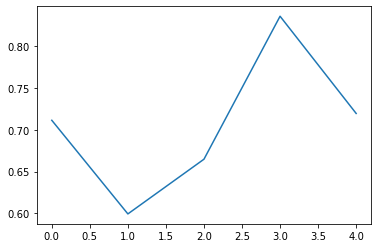

Best Score 0.8361191906208643


In [85]:
results = data_kfold_train(df, "alle parkhäuser", 5)
plt.plot(results)
plt.show()
print("Best Score " + str(results.max()))

# Resultat 
Im Resultat ersichtlich sind wieder die Feautures hour, is_weekend, day_of_week. Insgesamt wurden 5 Monate angeschaut (Juli, August, September, November, Dezember). Dabei wurde wie erwähnt über alle Parkhäuser einen durchschnittliche Auslastung errechnet und basiered auf diesem Wert pro Stunde eine Hervorsagequalität errechnet. Diese liegt für das Feauture Stunde (hour) zwischen 0.66 und 0.73. Also eine erstaunlich gute Berechnung. Mit dieser Hervorsage könnte also zum Beispiel auf einer Webseite ausgegeben werden: In der Stadt Zürich findest du in den nächsten Stunden mit ziemlich sicherer Wahrscheinlichkeit X% freie Parkplätze